# Testing for File Permanence and Human Yes/No interface

In [1]:
import numpy as np
import pyvista as pv

from structgeo.model import geo
import structgeo.plot as geovis
from structgeo.model import history as geohistory
import structgeo.probability as rv
from structgeo.data.file_manager import FileManager

import importlib

pv.set_jupyter_backend('static')

In [2]:
def reloader():
    importlib.reload(geo)
    importlib.reload(geovis)
    importlib.reload(geohistory)
    importlib.reload(rv)
reloader()

## Goal:
Make an interaface that will present generated models with a yes/no decision to save the model

In [3]:
# Set random seed for reproducibility
# random_seed = 1234
# np.random.seed(random_seed)


Loading models from ../database/sedimentary_plane
Model loaded from ../database/sedimentary_plane\model_0.pkl
Model loaded from ../database/sedimentary_plane\model_1.pkl
Model loaded from ../database/sedimentary_plane\model_2.pkl
Model loaded from ../database/sedimentary_plane\model_3.pkl
Model loaded from ../database/sedimentary_plane\model_4.pkl
Model loaded from ../database/sedimentary_plane\model_5.pkl
Model loaded from ../database/sedimentary_plane\model_6.pkl
Model loaded from ../database/sedimentary_plane\model_7.pkl
Model loaded from ../database/sedimentary_plane\model_8.pkl
Model loaded from ../database/sedimentary_plane\model_9.pkl
Model loaded from ../database/sedimentary_plane\model_10.pkl
Model loaded from ../database/sedimentary_plane\model_11.pkl
Model loaded from ../database/sedimentary_plane\model_12.pkl
Model loaded from ../database/sedimentary_plane\model_13.pkl
Model loaded from ../database/sedimentary_plane\model_14.pkl
Model loaded from ../database/sedimentary_pla

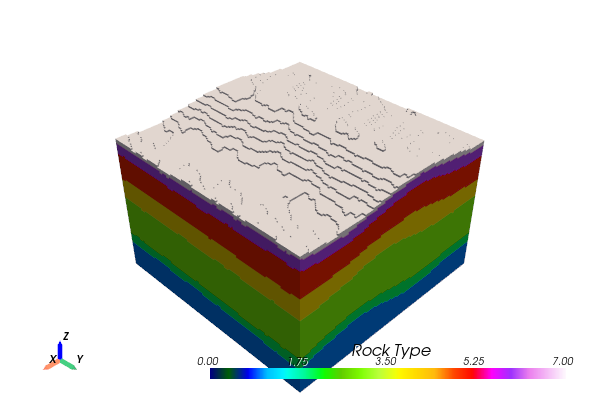

In [4]:
from structgeo.data.file_manager import FileManager

# Display the last saved model
fm = FileManager("../database/sedimentary_plane")
models = fm.load_all_models()
model = models[-1]
model.compute_model()
geovis.volview(model).show(window_size=[600, 400])

## Sedimentary Plane

In [5]:
from structgeo.data.model_reviewer import ModelReviewer

DEFAULT_BASE_DIR = "../database/sedimentary_plane"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

def generate_model():
    # Place the model generation logic here
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    height = min_x + model_size/2 + np.random.normal(1, model_size / 8)
    height = max(height, base + model_size/10)
    
    def thickness():
        avg_thickness = (height-base)/np.random.uniform(2, 15)
        return np.random.lognormal(np.log(avg_thickness), .1)
    
    bedrock = geo.Bedrock(base, 0)
    sediment = geo.Sedimentation(height, list(range(1, 100)), thickness_callable=thickness)
    
    # Add micro fold noise to the model
    def fold_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .18),
            'periodic_func': rv.fourier_series_wave(num_harmonics=5)
        }
    sediment_noise = [geo.Fold(**fold_params()) for _ in range(np.random.randint(3, 7))]
    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(30, 60),
            'amplitude': np.random.uniform(1.2),
            'periodic_func': None,
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]

    model.clear_history()
    model.add_history([bedrock, sediment] + sediment_noise + geo_noise)
    model.compute_model()
    return model


reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Model created with bounds (-10, 10) and resolution 128


Output()

# Sedimentary Plane with Dikes

In [82]:
from structgeo.data.model_reviewer import ModelReviewer

DEFAULT_BASE_DIR = "../database/sedimentary_plane_dikes"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

def generate_model():
    # Place the model generation logic here
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    height = min_x + model_size/2 + np.random.normal(1, model_size / 8)
    height = max(height, base + model_size/10)
    
    def thickness():
        avg_thickness = (height-base)/np.random.uniform(2, 15)
        return np.random.lognormal(np.log(avg_thickness), .1)
    
    bedrock = geo.Bedrock(base, 0)
    sediment = geo.Sedimentation(height, list(range(1, 100)), thickness_callable=thickness)
    
    # Add micro fold noise to the model
    def fold_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .08),
            'periodic_func': rv.fourier_series_wave(num_harmonics=5)
        }
    sediment_noise = [geo.Fold(**fold_params()) for _ in range(np.random.randint(3, 7))]
    
    # Recover the last layer of rock
    model.clear_history()
    model.add_history([bedrock, sediment])
    model.compute_model()
    model.clear_data()
    last_val = sediment.values_sequence_used[-1]

    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(30, 60),
            'amplitude': np.random.uniform(1.2),
            'periodic_func': None,
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]


    n_dikes = 2
    dike_rock_val = last_val+1
    def dike_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.normal(90, 25),
            'width': np.random.uniform(.05, 1),
            'origin': rv.random_point_in_ellipsoid(model.bounds),
            'value': dike_rock_val
        }
    params = dike_params()
    dike1 = geo.Dike(**params)
    
    noise_std = {
    'strike': 5,  # Noise standard deviation for 'strike'
    'dip': 5,     # Noise standard deviation for 'dip'
    'width': 0.4,  # Noise standard deviation for 'width'
    'origin': 1    # Noise standard deviation for 'origin'
}
    
    additional_dikes = []
    for i in range(n_dikes-1):
        width = params['width']
        dike_gap = (i+1)*(np.random.lognormal(.5, .5))
        strike_radians = np.deg2rad(params['strike'])
        print(f"Strike: {params['strike']}")
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0]) * dike_gap
        print(f"Gap direction: {gap_dir}")
        params['origin'] += gap_dir
        params['width'] += np.random.normal(0, noise_std['width'])
        params['strike'] += np.random.normal(0, noise_std['strike'])
        params['dip'] += np.random.normal(0, noise_std['dip'])
        # params['value'] += 1
        additional_dikes.append(geo.Dike(**params))
        
    model.add_history(sediment_noise + geo_noise  + [dike1]+ additional_dikes )
    model.compute_model()
    return model

Model created with bounds (-10, 10) and resolution 128


In [83]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Strike: 222.84414590250293
Gap direction: [-1.56620927  1.45256882  0.        ]


Output()

Model saved to ../database/sedimentary_plane_dikes\model_72.pkl


Model discarded.
Strike: 60.80747850235602
Gap direction: [ 1.02079267 -1.82705337  0.        ]


### Tilted Sedimentary Planes, with and without Dikes

In [125]:
from structgeo.data.model_reviewer import ModelReviewer

DEFAULT_BASE_DIR = "../database/tilted_sedimentary_plane_vardikes"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")


def generate_model():
    # Place the model generation logic here
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    height = min_x + model_size/2 + np.random.normal(1, model_size / 8)
    height = max(height, base + model_size/10)
    
    def thickness():
        avg_thickness = (height-base)/np.random.uniform(2, 15)
        return np.random.lognormal(np.log(avg_thickness), .1)
    
    bedrock = geo.Bedrock(base, 0)
    sediment = geo.Sedimentation(height, list(range(1, 100)), thickness_callable=thickness)
    
    # Add micro fold noise to the model
    def fold_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .08),
            'periodic_func': rv.fourier_series_wave(num_harmonics=5)
        }
    sediment_noise = [geo.Fold(**fold_params()) for _ in range(np.random.randint(3, 7))]
    
    # Recover the last layer of rock
    model.clear_history()
    model.add_history([bedrock, sediment])
    model.compute_model()
    model.clear_data()
    last_val = sediment.values_sequence_used[-1]

    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(15, 60),
            'amplitude': np.random.uniform(4),
            'periodic_func': rv.fourier_series_wave(num_harmonics=3),
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]

    n_dikes = 0
    dike_rock_val = last_val+1
    def dike_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.normal(90, 25),
            'width': np.random.uniform(.05, 1),
            'origin': rv.random_point_in_ellipsoid(model.bounds),
            'value': dike_rock_val
        }
    params = dike_params()
    
    dike1 = [geo.Dike(**params)] if n_dikes > 0 else []

    noise_std = {
    'strike': 5,  # Noise standard deviation for 'strike'
    'dip': 5,     # Noise standard deviation for 'dip'
    'width': 0.4,  # Noise standard deviation for 'width'
    'origin': 1    # Noise standard deviation for 'origin'
}
    
    additional_dikes = []
    for i in range(n_dikes-1):
        width = params['width']
        dike_gap = (i+1)*(np.random.lognormal(.5, .5))
        strike_radians = np.deg2rad(params['strike'])
        print(f"Strike: {params['strike']}")
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0]) * dike_gap
        print(f"Gap direction: {gap_dir}")
        params['origin'] += gap_dir
        params['width'] += np.random.normal(0, noise_std['width'])
        params['strike'] += np.random.normal(0, noise_std['strike'])
        params['dip'] += np.random.normal(0, noise_std['dip'])
        # params['value'] += 1
        additional_dikes.append(geo.Dike(**params))
     
    tilt_params = {
        'strike': np.random.uniform(0, 360),
        'dip': np.random.uniform(0, 30),
    }    
    tilt = geo.Tilt(**tilt_params)
    
    model.clear_history()    
    model.add_history([bedrock]+ dike1+ additional_dikes + [sediment] +  sediment_noise + geo_noise + [tilt] )
    model.compute_model()
    return model

Model created with bounds (-10, 10) and resolution 128


In [126]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Output()

Model saved to ../database/tilted_sedimentary_plane_vardikes\model_50.pkl


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model saved to ../database/tilted_sedimentary_plane_vardikes\model_51.pkl


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


### Second Sedimentation

In [88]:
from structgeo.data.model_reviewer import ModelReviewer

DEFAULT_BASE_DIR = "../database/second_sedimenation"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

# Start rock vals from 5 to give space for adding dikes without knowing sedimentation values
def generate_model():
    START_ROCK_VAL = 3
    next_rock_val = START_ROCK_VAL
    # Place the model generation logic here
    base = min_x + np.random.normal(1, 1)
    height = base + 2 + np.random.normal(1, 1)
    
    def thickness():
        avg_thickness = (height-base)/np.random.uniform(2, 8)
        return np.random.lognormal(np.log(avg_thickness), .2)
    
    bedrock = geo.Bedrock(base, next_rock_val)
    next_rock_val += 1
    sediment = geo.SedimentationDeterministic(list(range(next_rock_val, next_rock_val+5)), thickness_callable=thickness)   
     
    # Recover the last layer of rock
    model.clear_history()
    model.add_history([bedrock, sediment])
    model.compute_model()
    model.clear_data()
    next_rock_val = sediment.values_sequence_used[-1] + 1
    
    # Add micro fold noise to the model
    def noise_fold_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.02, .1),
            'periodic_func': rv.fourier_series_wave(num_harmonics=5)
        }
    sediment_noise = [geo.Fold(**noise_fold_params()) for _ in range(np.random.randint(3, 7))]
    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(10, 60),
            'amplitude': np.random.uniform(1,2),
            'periodic_func': None,
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]
    
    tilt_params = {
        'strike': np.random.uniform(0, 360),
        'dip': np.random.uniform(0, 30),
    }    
    tilt = geo.Tilt(**tilt_params)
    
    # Second Sedimentation
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    height = min_x + model_size/2 + np.random.normal(1, model_size / 8)
    height = max(height, base + model_size/10)
    
    def thickness2():
        avg_thickness = (height-base)/np.random.uniform(2, 8)
        return np.random.lognormal(np.log(avg_thickness), .1)
    
    nlayers = np.random.randint(4,10)
    sediment2 = geo.SedimentationDeterministic(list(range(next_rock_val, next_rock_val+nlayers)), thickness_callable=thickness2) 
    next_rock_val += nlayers    
        
    sediment_noise2 = [geo.Fold(**noise_fold_params()) for _ in range(np.random.randint(3, 4))]
    geo_noise2 = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]
    
    # Start at 0 
    dike_rock_val = START_ROCK_VAL - 1
    def dike_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.normal(90, 25),
            'width': np.random.uniform(.5, 1),
            'origin': rv.random_point_in_ellipsoid(model.bounds),
            'value': dike_rock_val
        }
        
    noise_std = {
    'strike': 5,  # Noise standard deviation for 'strike'
    'dip': 5,     # Noise standard deviation for 'dip'
    'width': 0.4,  # Noise standard deviation for 'width'
    'origin': 1    # Noise standard deviation for 'origin'
}   
    
    n_dikes = 0
    params = dike_params()
    dikes = []    
    for i in range(n_dikes):
        width = params['width']
        dike_gap = (i)*(np.random.lognormal(.5, .5))
        strike_radians = np.deg2rad(params['strike'])
        print(f"Strike: {params['strike']}")
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0]) * dike_gap
        print(f"Gap direction: {gap_dir}")
        params['origin'] += gap_dir
        params['width'] += np.random.normal(0, noise_std['width'])
        params['strike'] += np.random.normal(0, noise_std['strike'])
        params['dip'] += np.random.normal(0, noise_std['dip'])
        # params['value'] += 1
        dikes.append(geo.Dike(**params))

    model.clear_history()
    model.add_history([bedrock, sediment]  + geo_noise + [tilt] + [sediment2] + geo_noise2 + dikes + sediment_noise2 )

    model.compute_model()
    return model


Model created with bounds (-10, 10) and resolution 128


In [89]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Output()

Model saved to ../database/second_sedimenation\model_97.pkl


Model discarded.


Model discarded.


Model saved to ../database/second_sedimenation\model_98.pkl


Model discarded.


Model discarded.


In [1]:
import numpy as np
import pyvista as pv
import copy
import itertools

from structgeo.model import geo
import structgeo.plot as geovis
from structgeo.model import history as geohistory
import structgeo.probability as rv
from structgeo.data.file_manager import FileManager
from structgeo.data.model_reviewer import ModelReviewer

LOAD_FOLDER = "../database"
DEFAULT_BASE_DIR = "../augmented_sediment_models"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

# Load an existing model from file
models = FileManager(LOAD_FOLDER).load_all_models()
    # Select a random model from the loaded models and make a deep copy
model_cycler = itertools.cycle(models[170:-1])

def generate_model():

    model = copy.deepcopy(next(model_cycler))
    rotation_axis = (np.random.uniform(0,.15) ,np.random.uniform(0,.15),1)
    rotation_amount = np.random.uniform(0, 360)
    rotate = geo.Rotate(rotation_axis, rotation_amount)
    # make a random 3D shift vector
    shift_vector = (np.random.normal(0,3), np.random.normal(0,3), np.random.normal(0,3))
    shift = geo.Shift(shift_vector)
    model.add_history([rotate, shift])
    model.compute_model()
    bounds = model.get_z_bounds()
    zmin, zmax = bounds
    z_range = zmax - zmin
    target_height = zmin + z_range*np.random.normal(.8, .05)    
    print(f"Target height: {target_height}")
    model.renormalize_height(target_height)
    return model

model = generate_model()


Model created with bounds (-10, 10) and resolution 128
Loading models from ../database
Loading models from ../database\augmented_sediment_models
Loading models from ../database\second_sedimenation
Loading models from ../database\sedimentary_plane
Loading models from ../database\sedimentary_plane_dikes
Loading models from ../database\tilted_sedimentary_plane_vardikes
Target height: 5.113088108638717


: 

In [26]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Target height: 6.762862845380862


Output()

Model saved to ../augmented_sediment_models\model_157.pkl


Model saved to ../augmented_sediment_models\model_158.pkl


Model saved to ../augmented_sediment_models\model_159.pkl


Model saved to ../augmented_sediment_models\model_160.pkl


Model saved to ../augmented_sediment_models\model_161.pkl


Model saved to ../augmented_sediment_models\model_162.pkl


Model discarded.
Target height: 5.26241467250302


Model saved to ../augmented_sediment_models\model_163.pkl


Model saved to ../augmented_sediment_models\model_164.pkl


Model saved to ../augmented_sediment_models\model_165.pkl


Model saved to ../augmented_sediment_models\model_166.pkl


Model saved to ../augmented_sediment_models\model_167.pkl


Model saved to ../augmented_sediment_models\model_168.pkl


Model saved to ../augmented_sediment_models\model_169.pkl


Model saved to ../augmented_sediment_models\model_170.pkl


Model saved to ../augmented_sediment_models\model_171.pkl


Model saved to ../augmented_sediment_models\model_172.pkl


Model discarded.
Target height: 4.731275148381078


Model saved to ../augmented_sediment_models\model_173.pkl


Model saved to ../augmented_sediment_models\model_174.pkl


Model saved to ../augmented_sediment_models\model_175.pkl


Model saved to ../augmented_sediment_models\model_176.pkl


Model saved to ../augmented_sediment_models\model_177.pkl


Model saved to ../augmented_sediment_models\model_178.pkl


Model saved to ../augmented_sediment_models\model_179.pkl


Model discarded.
Target height: 4.625060358148296


Model saved to ../augmented_sediment_models\model_180.pkl


Model discarded.
Target height: 9.800088587878108


Model saved to ../augmented_sediment_models\model_181.pkl


Model saved to ../augmented_sediment_models\model_182.pkl


Model saved to ../augmented_sediment_models\model_183.pkl


Model saved to ../augmented_sediment_models\model_184.pkl


Model saved to ../augmented_sediment_models\model_185.pkl


Model saved to ../augmented_sediment_models\model_186.pkl


Model saved to ../augmented_sediment_models\model_187.pkl


Model saved to ../augmented_sediment_models\model_188.pkl


Model saved to ../augmented_sediment_models\model_189.pkl


Model saved to ../augmented_sediment_models\model_190.pkl


Model saved to ../augmented_sediment_models\model_191.pkl


Model saved to ../augmented_sediment_models\model_192.pkl


Model saved to ../augmented_sediment_models\model_193.pkl


Model saved to ../augmented_sediment_models\model_194.pkl


Model saved to ../augmented_sediment_models\model_195.pkl


Model saved to ../augmented_sediment_models\model_196.pkl


Model saved to ../augmented_sediment_models\model_197.pkl


Model saved to ../augmented_sediment_models\model_198.pkl


Model saved to ../augmented_sediment_models\model_199.pkl


Model saved to ../augmented_sediment_models\model_200.pkl


Model saved to ../augmented_sediment_models\model_201.pkl


Model saved to ../augmented_sediment_models\model_202.pkl


Model saved to ../augmented_sediment_models\model_203.pkl


Model saved to ../augmented_sediment_models\model_204.pkl


Model saved to ../augmented_sediment_models\model_205.pkl


Model saved to ../augmented_sediment_models\model_206.pkl


Model saved to ../augmented_sediment_models\model_207.pkl


Model saved to ../augmented_sediment_models\model_208.pkl


Model saved to ../augmented_sediment_models\model_209.pkl


Model saved to ../augmented_sediment_models\model_210.pkl


Model saved to ../augmented_sediment_models\model_211.pkl


Model saved to ../augmented_sediment_models\model_212.pkl


Model saved to ../augmented_sediment_models\model_213.pkl


Model saved to ../augmented_sediment_models\model_214.pkl


Model discarded.
Target height: 4.997275697748346


Model saved to ../augmented_sediment_models\model_215.pkl


Model saved to ../augmented_sediment_models\model_216.pkl


Model saved to ../augmented_sediment_models\model_217.pkl


Model saved to ../augmented_sediment_models\model_218.pkl


Model saved to ../augmented_sediment_models\model_219.pkl


Model saved to ../augmented_sediment_models\model_220.pkl


Model saved to ../augmented_sediment_models\model_221.pkl


Model saved to ../augmented_sediment_models\model_222.pkl


Model saved to ../augmented_sediment_models\model_223.pkl


Model saved to ../augmented_sediment_models\model_224.pkl


Model saved to ../augmented_sediment_models\model_225.pkl


Model discarded.
Target height: 6.373213343279524


Model saved to ../augmented_sediment_models\model_226.pkl


Model discarded.
Target height: 5.024848757938107


Model saved to ../augmented_sediment_models\model_227.pkl


Model saved to ../augmented_sediment_models\model_228.pkl


Model saved to ../augmented_sediment_models\model_229.pkl


Model discarded.
Target height: 7.462607739601317


Model discarded.
Target height: 6.4522090725022565


Model discarded.
Target height: 5.037894237754372


Model discarded.
Target height: 4.996617870069688


Model discarded.
Target height: 6.291957432496012


Model saved to ../augmented_sediment_models\model_230.pkl


Model discarded.
Target height: 7.1299533517226585


Model discarded.
Target height: 6.445189524434959


Model saved to ../augmented_sediment_models\model_231.pkl


Model saved to ../augmented_sediment_models\model_232.pkl


Model saved to ../augmented_sediment_models\model_233.pkl


Model saved to ../augmented_sediment_models\model_234.pkl


Model discarded.
Target height: 7.555398120911438


Model discarded.
Target height: 4.503559836315834


Model saved to ../augmented_sediment_models\model_235.pkl


Model saved to ../augmented_sediment_models\model_236.pkl


Model saved to ../augmented_sediment_models\model_237.pkl


Model discarded.
Target height: 5.602652840208879


Model discarded.
Target height: 5.555697110243102


Model discarded.
Target height: 6.67859855863329


Model saved to ../augmented_sediment_models\model_238.pkl


Model saved to ../augmented_sediment_models\model_239.pkl


Model saved to ../augmented_sediment_models\model_240.pkl


Model discarded.
Target height: 4.6924421882413405


Model saved to ../augmented_sediment_models\model_241.pkl


Model discarded.
Target height: 5.704676904542067


Model saved to ../augmented_sediment_models\model_242.pkl


Model saved to ../augmented_sediment_models\model_243.pkl


Model saved to ../augmented_sediment_models\model_244.pkl


Model saved to ../augmented_sediment_models\model_245.pkl


Model saved to ../augmented_sediment_models\model_246.pkl


Model saved to ../augmented_sediment_models\model_247.pkl


Model saved to ../augmented_sediment_models\model_248.pkl


Model saved to ../augmented_sediment_models\model_249.pkl


Model saved to ../augmented_sediment_models\model_250.pkl


Model saved to ../augmented_sediment_models\model_251.pkl


Model saved to ../augmented_sediment_models\model_252.pkl


Model saved to ../augmented_sediment_models\model_253.pkl


Model saved to ../augmented_sediment_models\model_254.pkl


Model saved to ../augmented_sediment_models\model_255.pkl


Model discarded.
Target height: 4.583354625218018


Model saved to ../augmented_sediment_models\model_256.pkl


Model discarded.
Target height: 5.063613480315109


Model saved to ../augmented_sediment_models\model_257.pkl


Model saved to ../augmented_sediment_models\model_258.pkl


Model saved to ../augmented_sediment_models\model_259.pkl


Model discarded.
Target height: 5.669747660921034


Model saved to ../augmented_sediment_models\model_260.pkl


Model saved to ../augmented_sediment_models\model_261.pkl


Model saved to ../augmented_sediment_models\model_262.pkl


Model saved to ../augmented_sediment_models\model_263.pkl


Model saved to ../augmented_sediment_models\model_264.pkl


Model discarded.
Target height: 5.879255228152161


Model discarded.
Target height: 6.475874829553124


In [1]:
## Update all of the saved pickled models by loading all of them and saving them again
from structgeo.data.file_manager import FileManager

fm = FileManager()
print(fm)
fm.update_all_models(load_dir="../database")

Loading models from ../database
Loading models from ../database\augmented_sediment_models
saving model ../database\augmented_sediment_models\model_0.pkl
Model saved to ../saved_models\model_0.pkl
saving model ../database\augmented_sediment_models\model_1.pkl
Model saved to ../saved_models\model_1.pkl
saving model ../database\augmented_sediment_models\model_2.pkl
Model saved to ../saved_models\model_2.pkl
saving model ../database\augmented_sediment_models\model_3.pkl
Model saved to ../saved_models\model_3.pkl
saving model ../database\augmented_sediment_models\model_4.pkl
Model saved to ../saved_models\model_4.pkl
saving model ../database\augmented_sediment_models\model_5.pkl
Model saved to ../saved_models\model_5.pkl
saving model ../database\augmented_sediment_models\model_6.pkl
Model saved to ../saved_models\model_6.pkl
saving model ../database\augmented_sediment_models\model_7.pkl
Model saved to ../saved_models\model_7.pkl
saving model ../database\augmented_sediment_models\model_8.pkl

# Add fault/ shear/ slip

Loading models from ../database
Loading models from ../database\augmented_sediment_models
Loading models from ../database\second_sedimenation
Loading models from ../database\sedimentary_plane
Loading models from ../database\sedimentary_plane_dikes
Loading models from ../database\tilted_sedimentary_plane_vardikes


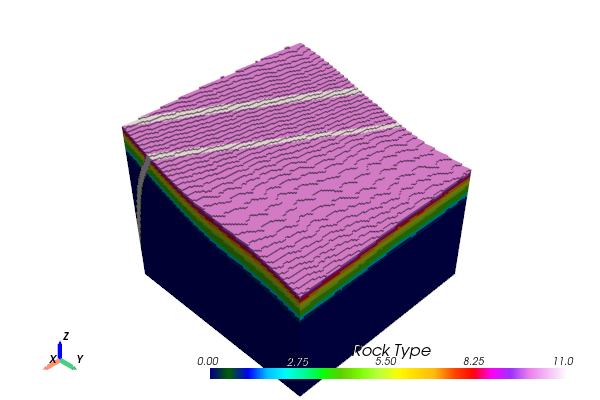

In [50]:
import numpy as np
import pyvista as pv
import copy
import itertools

from structgeo.model import geo
import structgeo.plot as geovis
from structgeo.model import history as geohistory
import structgeo.probability as rv
from structgeo.data.file_manager import FileManager
from structgeo.data.model_reviewer import ModelReviewer
pv.set_jupyter_backend('static')

LOAD_FOLDER = "../database"
DEFAULT_BASE_DIR = "../faulted_models"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)

# Load an existing model from file
models = FileManager(LOAD_FOLDER).load_all_models()

# Single model loader
#models = FileManager("../faulted_models").load_all_models()

# Select a random model from the loaded models and make a deep copy
model = np.random.choice(models)
demo_model = models

def get_history():
    """ Make an appended slip based history to add"""

    def fault_sequence(n_faults):
        # Random fault line
        strike = np.random.uniform(0, 360)
        dip = np.random.normal(80,5)
        rake = np.random.uniform(0, 180)
        amplitude = np.random.uniform(.1, .3)
        origin = rv.random_point_in_ellipsoid(model.bounds)    
        strike_radians = np.deg2rad(strike)
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0])
        
        def parameters():
            params = {
            'strike': strike + np.random.normal(0, 3),
            'dip': dip + np.random.normal(0, 2),
            'rake': rake + np.random.uniform(0, 5),
            'amplitude': amplitude + np.random.normal(0, .2),
            'steepness': np.random.normal(1,.1),
            'origin': origin + np.random.normal(.2, .2)*gap_dir,
        }
            return params
    
        faults = []
        for _ in range(n_faults):
            params = parameters()
            faults.append(geo.Shear(**params))            
        return faults
    
    n_faults = 1
    return fault_sequence(n_faults)

def generate_model():
    # Select a random model from the loaded models and make a deep copy
    demo_model = np.random.choice(models)
    model = copy.deepcopy(demo_model)   
    
    # Shuffle the view a bit
    # rotation_axis = (np.random.uniform(0,.05) ,np.random.uniform(0,.05),1)
    # rotation_amount = np.random.uniform(0, 360)
    # rotate = geo.Rotate(rotation_axis, rotation_amount)
    # shift_vector = (np.random.normal(0,1), np.random.normal(0,1), np.random.normal(0,1))
    # shift = geo.Shift(shift_vector)
    # model.add_history([rotate, shift])
    
    # Add some fault history
    model.add_history(get_history())
    model.compute_model()
    model.renormalize_height(auto = True)
    return model

model = generate_model()

geovis.volview(model).show(window_size=[600, 400])

In [51]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Output()

Model discarded.


Model discarded.


Model discarded.
